In [ ]:
## Question 3 - Average time it takes for outages to get fixed per neighborhood? (Alap)
## 1. Use current boundaries
## 2. Visuals: Average time per neighbourhood (bar chart or scatter chart, by year)
## 3. Average time per month for all neighborhoods (Line Chart - 1 line per year).

In [2]:
import pandas as pd
import requests
import json
import numpy as np
from Resources.config import app_token
import matplotlib.pyplot as plt

In [3]:
## Source: Crimes - 2001 to present
## https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
url_crime_data = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"
date_filter="$WHERE=DATE BETWEEN '2014-01-01' AND '2018-12-31'"
crime_records_limit = 1000
## Total # 1344565
url_crime_data_with_filter = f"{url_crime_data}?{date_filter}&$limit={crime_records_limit}&$$app_token={app_token}"
crime_data_json = requests.get(url_crime_data_with_filter).json()
#print(json.dumps(crime_data_json, indent=4, sort_keys=True))

In [4]:
## Convert to pandas DataFrame
crime_data_df = pd.DataFrame.from_records(crime_data_json)
## drop extra columns
crime_data_df = crime_data_df.drop(['x_coordinate','y_coordinate','latitude','longitude','location'],axis=1)

In [5]:
## Source: Boundaries - Community Areas (current)
## https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6
## Call to get data from city of chicago API in json format
url_comm_area = "https://data.cityofchicago.org/resource/igwz-8jzy.json"
field_filter = "$select=community,area_numbe"
url_comm_area_with_filter = f"{url_comm_area}?{field_filter}&$order=area_numbe&$$app_token={app_token}"
comm_data_json = requests.get(url_comm_area_with_filter).json()

In [6]:
## Convert to pandas DataFrame
comm_data_df = pd.DataFrame.from_records(comm_data_json)
## Convert area numbers to integer
comm_data_df['area_numbe'] = pd.to_numeric(comm_data_df['area_numbe'],downcast='integer')
comm_data_df

,community,area_numbe
0,ROGERS PARK,1
1,NORWOOD PARK,10
2,JEFFERSON PARK,11
3,FOREST GLEN,12
4,NORTH PARK,13
...,...,...
72,MORGAN PARK,75
73,OHARE,76
74,EDGEWATER,77
75,NEAR NORTH SIDE,8


In [7]:
## 311 Service Requests - Street Lights - All Out
## https://data.cityofchicago.org/Service-Requests/311-Service-Requests-Street-Lights-All-Out-No-Dupl/756k-itxx
## Call to get data from city of chicago API in json format
url_service_requests = "https://data.cityofchicago.org/resource/zuxi-7xem.json"
status_filter = "$select=creation_date,status,completion_date,service_request_number,type_of_service_request,community_area&$where=creation_date between '2014-01-01' AND '2018-12-31'"
service_requests_limit = 100000
## Total 97560
url_service_requests_with_filter = f"{url_service_requests}?{status_filter}&$limit={service_requests_limit}&$$app_token={app_token}"
service_requests_json = requests.get(url_service_requests_with_filter).json()

In [8]:
## Convert to pandas DataFrame
service_requests_df = pd.DataFrame.from_records(service_requests_json)
## Drop rows with missing community area
service_requests_df = service_requests_df.dropna(how="any",subset=['community_area'])
## Cast community_area to integer
service_requests_df['community_area'] = pd.to_numeric(service_requests_df['community_area'],downcast='integer')
#service_requests_df.astype({'community_area': 'int32','completion_date':'datetime64'}).dtypes
service_requests_df['creation_year'] = pd.DatetimeIndex(service_requests_df['creation_date']).year
service_requests_df['creation_month'] = pd.DatetimeIndex(service_requests_df['creation_date']).month

In [9]:
## Join 2 tables to display community names.
service_requests_by_community = pd.merge(service_requests_df, comm_data_df, left_on="community_area", right_on="area_numbe", how="left")
## Delete extra column
del service_requests_by_community["area_numbe"]
## Calculate service requests resolution time after setting completion_date to current date if N/A
service_requests_by_community['resolution_time(days)'] = (pd.to_datetime(service_requests_by_community['completion_date'].fillna(pd.datetime.now().date())) - pd.to_datetime(service_requests_by_community['creation_date'])).dt.days
service_requests_by_community

,creation_date,status,completion_date,service_request_number,type_of_service_request,community_area,creation_year,creation_month,community,resolution_time(days)
0,2014-01-01T00:00:00.000,Completed,2014-01-06T00:00:00.000,14-00002286,Street Lights - All/Out,29,2014,1,NORTH LAWNDALE,5
1,2014-01-01T00:00:00.000,Completed - Dup,2014-01-06T00:00:00.000,14-00001878,Street Lights - All/Out,44,2014,1,CHATHAM,5
2,2014-01-01T00:00:00.000,Completed,2014-01-03T00:00:00.000,14-00001931,Street Lights - All/Out,30,2014,1,SOUTH LAWNDALE,2
3,2014-01-01T00:00:00.000,Completed,2014-01-03T00:00:00.000,14-00001932,Street Lights - All/Out,30,2014,1,SOUTH LAWNDALE,2
4,2014-01-01T00:00:00.000,Completed - Dup,2014-01-08T00:00:00.000,14-00001100,Street Lights - All/Out,68,2014,1,ENGLEWOOD,7
...,...,...,...,...,...,...,...,...,...,...
97537,2018-12-18T00:00:00.000,Open,NaN,18-03388032,Street Lights - All/Out,17,2018,12,DUNNING,392
97538,2018-12-18T00:00:00.000,Open,NaN,18-03388097,Street Lights - All/Out,71,2018,12,AUBURN GRESHAM,392
97539,2018-12-18T00:00:00.000,Open,NaN,18-03387792,Street Lights - All/Out,71,2018,12,AUBURN GRESHAM,392
97540,2018-12-18T00:00:00.000,Open,NaN,18-03387790,Street Lights - All/Out,43,2018,12,SOUTH SHORE,392


In [10]:
## Filter out rows where community_area = 0 OR service_request_number is duplicate 
service_requests_by_community = service_requests_by_community.loc[(service_requests_by_community['community_area']!=0)]
service_requests_by_community = service_requests_by_community.drop_duplicates(subset="service_request_number")

In [11]:
service_requests_by_community_average_time = service_requests_by_community.groupby(["community","creation_year"])["resolution_time(days)"].mean()
#service_requests_by_community_average_time = pd.merge(service_requests_by_community_average_time, comm_data_df, left_on="community_area", right_on="area_numbe", how="left")
service_requests_by_community_average_time.sort_values(ascending=False)

community        creation_year
OHARE            2018             44.808511
LOOP             2018             37.626866
NEAR SOUTH SIDE  2018             34.532468
HEGEWISCH        2018             33.378788
FULLER PARK      2014             28.800000
                                    ...    
LINCOLN SQUARE   2017              2.172619
UPTOWN           2017              2.147727
NORTH CENTER     2017              2.137500
ARMOUR SQUARE    2018              2.017544
BRIDGEPORT       2017              1.789474
Name: resolution_time(days), Length: 385, dtype: float64

In [12]:
service_requests_by_community_average_time = pd.DataFrame(service_requests_by_community_average_time).reset_index()

In [13]:
service_requests_by_community_average_time_2014 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["creation_year"] == 2014].sort_values(by="resolution_time(days)",ascending=False)
service_requests_by_community_average_time_2015 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["creation_year"] == 2015].sort_values(by="resolution_time(days)",ascending=False)
service_requests_by_community_average_time_2016 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["creation_year"] == 2016].sort_values(by="resolution_time(days)",ascending=False)
service_requests_by_community_average_time_2017 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["creation_year"] == 2017].sort_values(by="resolution_time(days)",ascending=False)
service_requests_by_community_average_time_2018 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["creation_year"] == 2018].sort_values(by="resolution_time(days)",ascending=False)


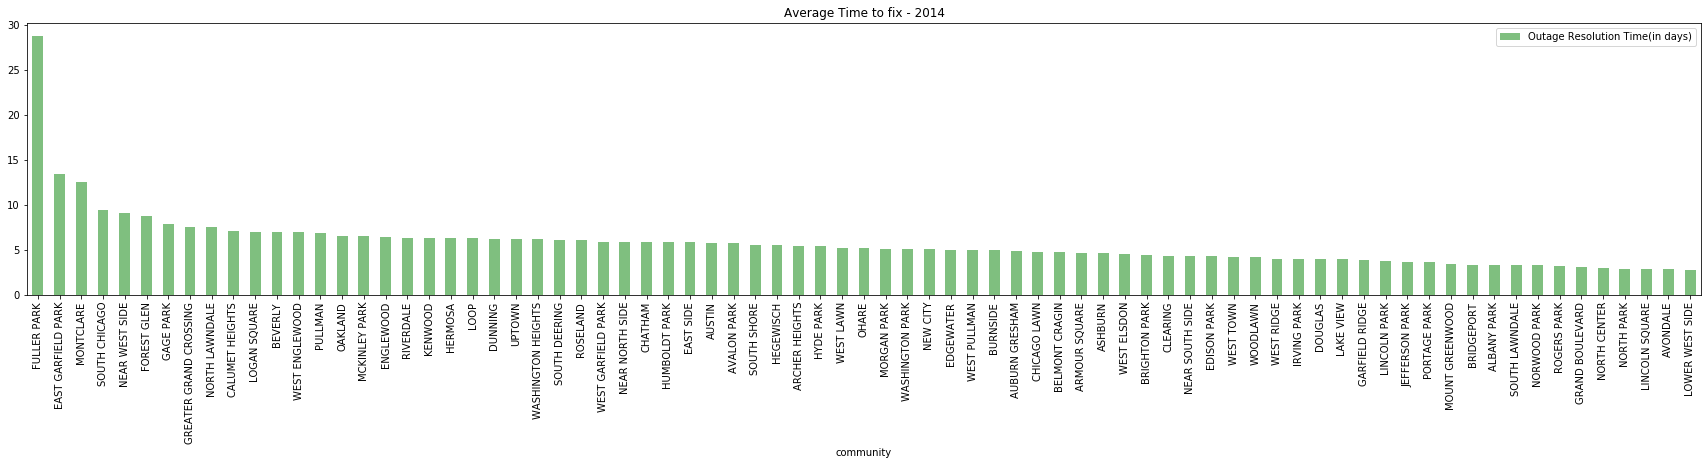

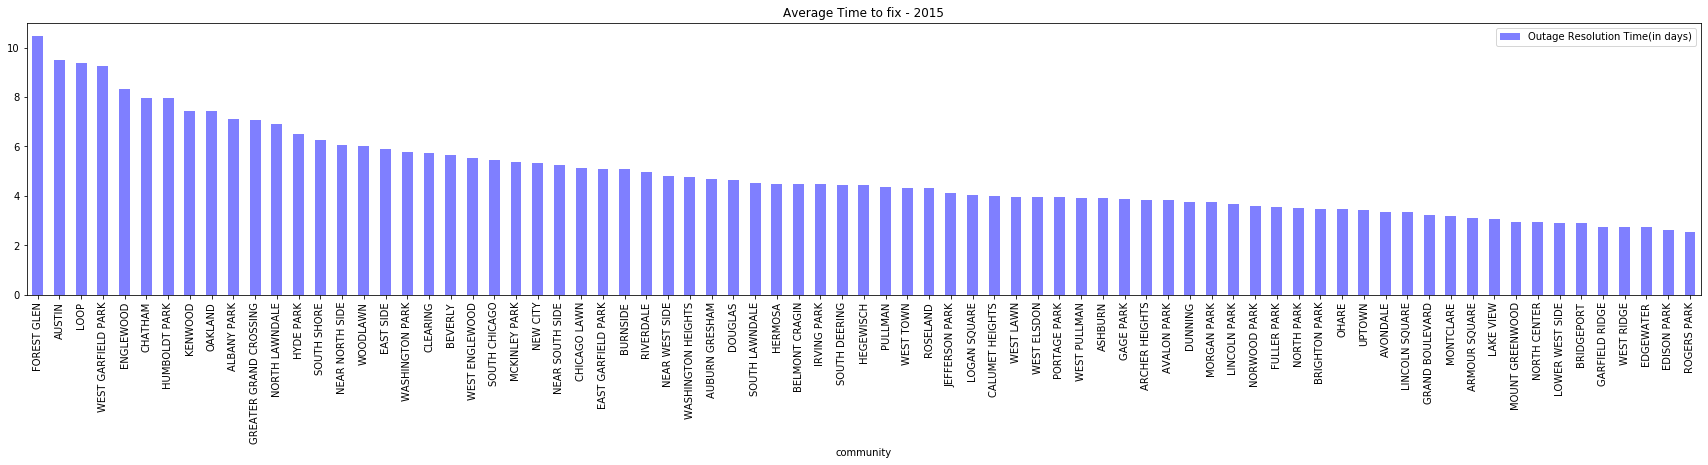

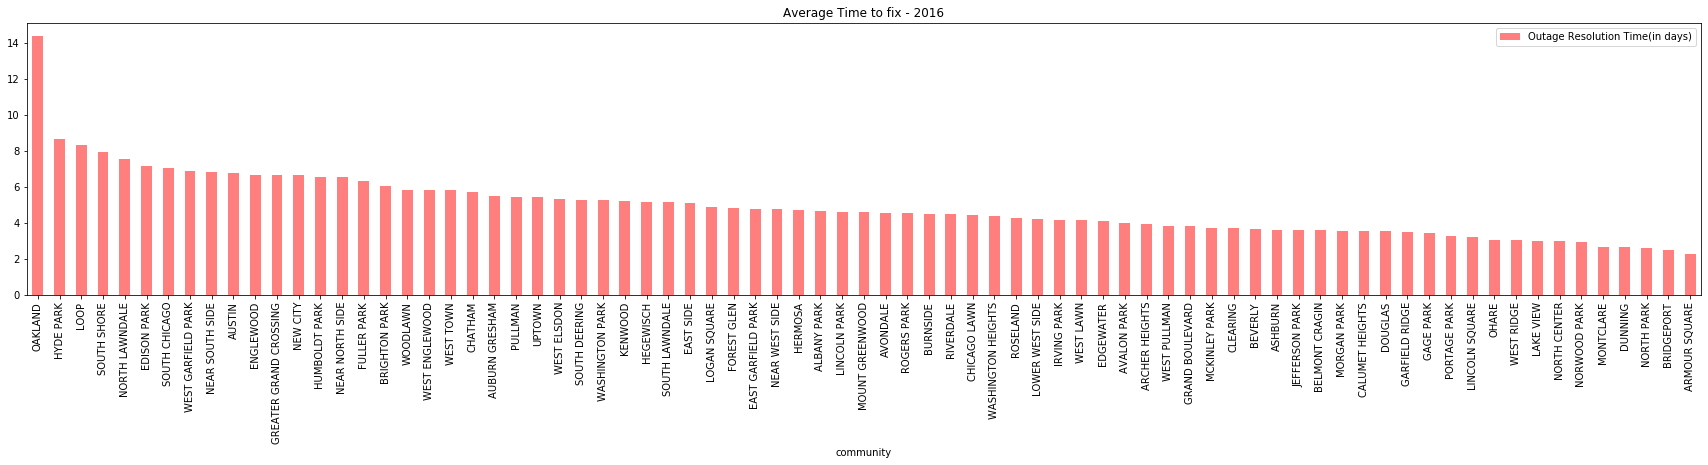

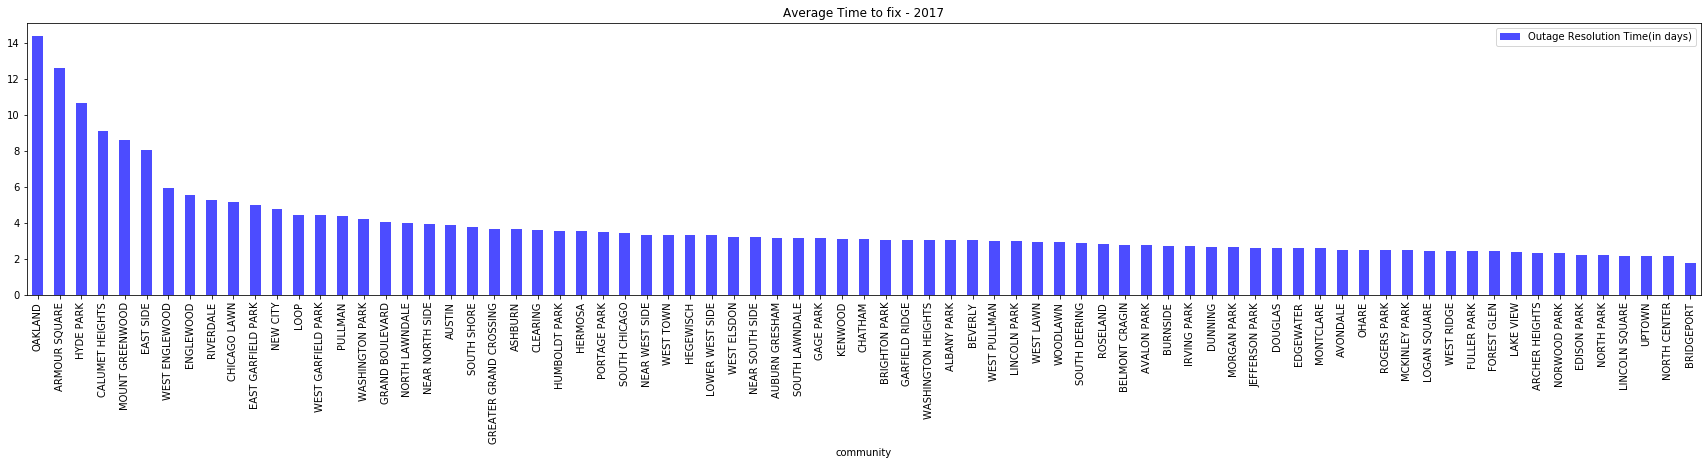

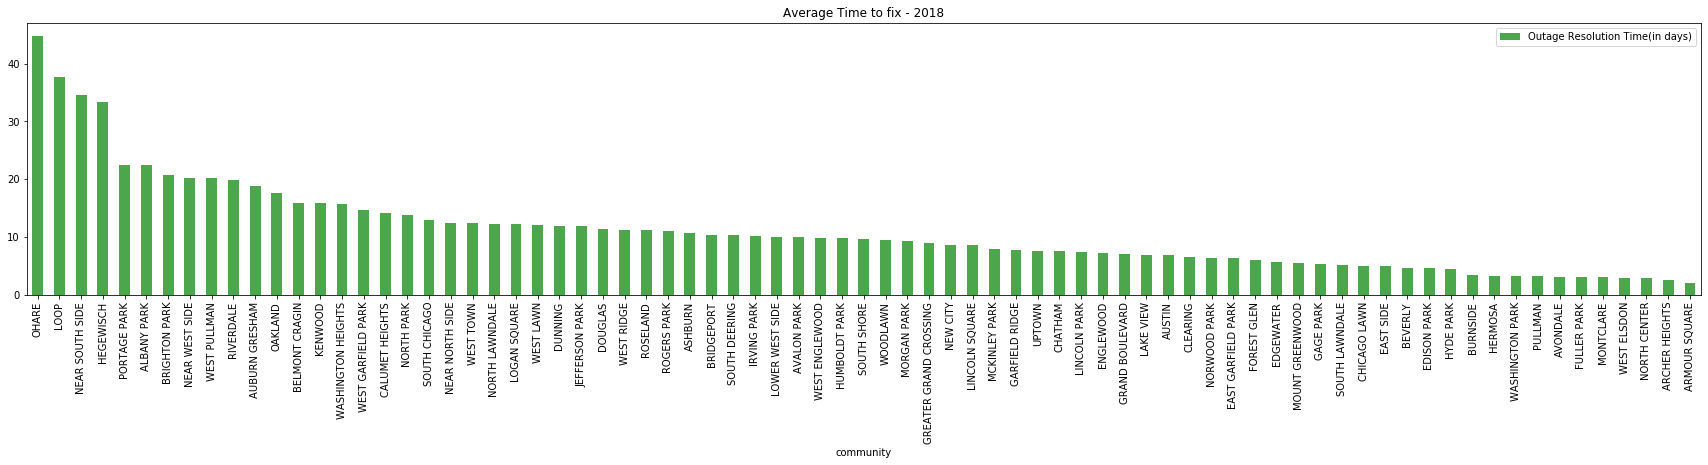

In [23]:
average_time_chart_2014 = service_requests_by_community_average_time_2014.plot.bar(y='resolution_time(days)', x='community', label="Outage Resolution Time(in days)",alpha=0.5, align="center", color="green", rot=90, figsize=(30,5), title="Average Time to fix - 2014")
#average_time_chart_2014 = average_time_chart_2014.set_xlabel("Community Area')
plt.savefig("Charts/average_time_chart_2014.png", bbox_inches = 'tight')
average_time_chart_2015 = service_requests_by_community_average_time_2015.plot.bar(y='resolution_time(days)', x='community', label="Outage Resolution Time(in days)", alpha=0.5, align="center", color="blue", rot=90, figsize=(30,5), title="Average Time to fix - 2015")
plt.savefig("Charts/average_time_chart_2015.png", bbox_inches = 'tight')
average_time_chart_2016 = service_requests_by_community_average_time_2016.plot.bar(y='resolution_time(days)', x='community', label="Outage Resolution Time(in days)", alpha=0.5, align="center", color="red", rot=90, figsize=(30,5), title="Average Time to fix - 2016")
plt.savefig("Charts/average_time_chart_2016.png", bbox_inches = 'tight')
average_time_chart_2017 = service_requests_by_community_average_time_2017.plot.bar(y='resolution_time(days)', x='community', label="Outage Resolution Time(in days)", alpha=0.7, align="center", color="blue", rot=90, figsize=(30,5), title="Average Time to fix - 2017")
plt.savefig("Charts/average_time_chart_2017.png", bbox_inches = 'tight')
average_time_chart_2018 = service_requests_by_community_average_time_2018.plot.bar(y='resolution_time(days)', x='community', label="Outage Resolution Time(in days)", alpha=0.7, align="center", color="green", rot=90, figsize=(30,5), title="Average Time to fix - 2018")
plt.savefig("Charts/average_time_chart_2018.png", bbox_inches = 'tight')